In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit

# Graphing
from graph_config import plt
import seaborn as sns

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


### Parameters
* Population: 22000
	* https://www.orkney.gov.uk/media/l5zio0cj/economic_review_2017.pdf
* 2 Rooms / household <- including living room:
	* 2 heater in total (QM070RF) -> Input 1.56 Kw | Storage 10.92 kWh
	* 1 water cylinder per household () | Input  3 Kw | Storage 7.1kWh | 125l 
* 41% use electric heating
* 59% other/including oil

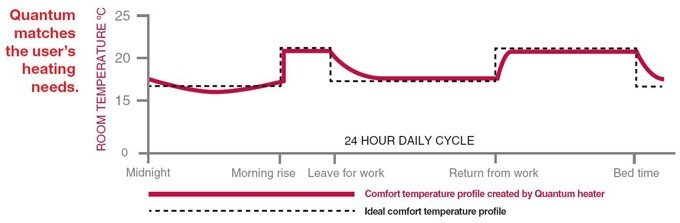

| Location             | Storage Heaters | Megaflo Cylinders | MacGregor Cylinders | Immersion Elements |
|----------------------|------------------|--------------------|----------------------|---------------------|
| Rousay              | 36               | 29                 | -                    | 2                   |
| Egilsay             | 2                | 2                  | -                    | -                   |
| Wyre                | -                | 1                  | -                    | -                   |
| Papa Westray        | -                | 3                  | -                    | -                   |
| Westray             | -                | 14                 | -                    | 1                   |
| Eday                | 1                | 2                  | 1                    | -                   |
| N.E. of West Mainland | 3              | 12                 | 2                    | 2                   |
| **Total**           | **42**           | **63**             | **3**                | **5**               |

Types of Heater:
* Direct -> Boiler is on the machine high electricity usage
* Indirect -> Boiler is external (gas, oil, solid fuel) sent to the boiler to be kept hot

"During the installation process, it became clear that 3 of the properties would require
alternatives to the Megaflo cylinder (see section 4.2.2), **which could not be used with solid
fuel boilers without the installation of an expansion vessel**, costing an additional £800 per
property. R S Merriman sourced a copper cylinder from MacGregor cylinders, which was a
suitable alternative to the Megaflo cylinder within a similar budge"

The bold text indicate that they use the indirect cylinder so the 



In [124]:
ts_curtailment = pd.read_csv(PROCESSED_DATASET_PATH / 'ts_curtailment_calculated.csv', index_col=0, parse_dates=True)

ts_curtailment.head()

,Wind_ms,Temperature_c,Turbine_power_kw,Turbine_energy_kwh,Res_demand_kw,Res_energy_kwh,Season,Day,Time,Hour,Res_energy_total_kwh,Turbine_energy_total_kwh,Excess_energy,Export_probability,Can_export,Export_energy_kwh,Curtailment_energy_kwh
Timestamp,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,13.820000,NaN,894.033333,447.016667,0.220106,0.110053,Winter,2017-01-01,00:00:00,0,1139.931485,223508.333333,222368.401848,0.094162,True,20000.0,202368.401848
2017-01-01 00:30:00,16.106667,5.0,898.266667,449.133333,0.205945,0.102973,Winter,2017-01-01,00:30:00,0,1066.589723,224566.666667,223500.076944,0.139879,True,20000.0,203500.076944
2017-01-01 01:00:00,16.380000,6.1,902.866667,451.433333,0.189090,0.094545,Winter,2017-01-01,01:00:00,1,979.296528,225716.666667,224737.370139,0.502150,True,20000.0,204737.370139
2017-01-01 01:30:00,17.083333,5.0,907.833333,453.916667,0.173118,0.086559,Winter,2017-01-01,01:30:00,1,896.578483,226958.333333,226061.754851,0.975251,False,0.0,226061.754851
2017-01-01 02:00:00,16.800000,3.9,907.000000,453.500000,0.159051,0.079525,Winter,2017-01-01,02:00:00,2,823.723337,226750.000000,225926.276663,0.852203,False,0.0,225926.276663


In [128]:
22000/10358

2.12396215485615

# Modelling Heating with Electricity

Orkney’s use of electricity is well above average. According to the Scottish Government’s Energy in Scotland figures published in 2016, the average yearly electricity KWh consumption figure for the United Kingdom was 4,092 in 2014. Scotland had a figure of 4,465, while Orkney came second only to Shetland with a figure of **8,193**, which is over 83% higher than the Scottish average. This higher average electricity use in Orkney evidences the reliance on electricity as one of the three main heating types in Orkney. Orkney’s Affordable Warmth Survey put the use of electric heating at 43%, very close to the 41% identified in the 2011 Census.

electric_heating_household = 43%
other_heating_household = 57%



In [145]:
annual_residential_energy = ts_curtailment.Res_energy_kwh.sum()

# assuming that this is only appliance and doesnt include heating and space heating is 70% of energy
space_heating_energy =  annual_residential_energy/(1-0.7)

total_energy = annual_residential_energy + space_heating_energy

print(f"Annual residential energy consumption: {annual_residential_energy:.2f} kWh")
print(f"Annual space heating energy consumption: {space_heating_energy:.2f} kWh")
print(f"Total annual energy consumption: {total_energy:.2f} kWh")

Annual residential energy consumption: 1918.29 kWh
Annual space heating energy consumption: 6394.29 kWh
Total annual energy consumption: 8312.58 kWh


In [146]:
ts_electric_model = pd.DataFrame(
    data={
        "seasons": ts_curtailment["Season"],
        "hour": ts_curtailment["Hour"],
        "day": ts_curtailment["Day"],
    },
    index=ts_curtailment.index,
)  # initialize the model with the same index as the combined dataset the adopted households and

# Heating Season

heating_distribution = {
    'Winter': 0.50,
    'Spring': 0.25,
    'Autumn': 0.25,
    'Summer': 0.0
}

heating_energy = {
    season: space_heating_energy * fraction
    for season, fraction in heating_distribution.items()
}

# Define heating hours (6–8 AM and 4–10 PM = 6 hours = 12 slots/day)
heating_hours = list(range(6, 9)) + list(range(16, 23))  # 30-min interval data

# Add a column to store heating energy
ts_electric_model["space_heating_kWh"] = 0.0

# Step 1: Count how many 30-min slots exist per season during heating hours
season_slot_counts = {season: 0 for season in heating_distribution}

for i in range(len(ts_electric_model)):
    row = ts_electric_model.iloc[i]
    if row['hour'] in heating_hours:
        season_slot_counts[row['seasons']] += 1

# Step 2: Compute energy per 30-minute slot for each season
season_energy_per_slot = {
    season: (heating_energy[season] / count if count > 0 else 0)
    for season, count in season_slot_counts.items()
}

# Step 3: Assign energy to each 30-min slot
for i in tqdm.tqdm(range(len(ts_electric_model))):
    row = ts_electric_model.iloc[i]
    if row['hour'] in heating_hours:
        season = row['seasons']
        ts_electric_model.iat[i, ts_electric_model.columns.get_loc("space_heating_kWh")] = season_energy_per_slot[season]

100%|██████████| 17503/17503 [00:01<00:00, 12341.72it/s]


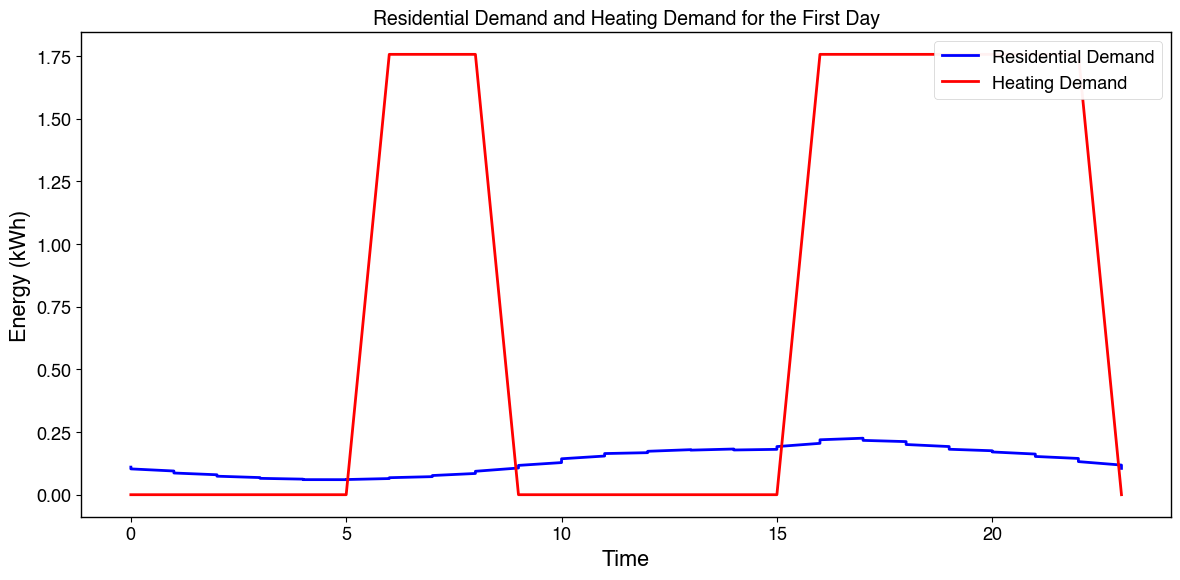

In [147]:
# plot the residential demand + heating model in a plot for average day in winter
day_1_residential = ts_curtailment.head(48)
day_1_heating = ts_electric_model.head(48)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(day_1_residential.index.hour, day_1_residential['Res_energy_kwh'], label='Residential Demand', color='blue')
plt.plot(day_1_heating.index.hour, day_1_heating['space_heating_kWh'], label='Heating Demand', color='red')
plt.title('Residential Demand and Heating Demand for the First Day')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [155]:
print((ts_electric_model['space_heating_kWh'].sum())*0.15)
print((ts_curtailment['Res_energy_kwh'].sum())*0.15)
print((ts_model['qheater_charging_energy_kwh'].sum()/(n_adopted_households))*0.12)

959.143673340486
287.74310200214586
330.1051200000001


# Modelling Heating with oil Usage

Buildings account for the largest share of Orkney’s energy use at an estimated 264.3 GWh, or almost 35%. The bulk of
this is electricity at 138.1 GWh, or 54% and Kerosene at 117.3 GWh, 46%. Kerosene is mainly used for heating, with
the vast majority (over 90%) used in the domestic sector, followed by the commercial and public administration sectors.
Data has been collated from the UK Government department for Business Energy and Industrial Strategy (BEIS) sources. 

Overall 41% of Orkney’s households rely on electric heating while 36% of households rely on oil.

In [ ]:
(((117.3*0.9)*(10**6))/(10358*0.36)) #kwh

28311.450086889363

In [ ]:
ts_oil_model = pd.DataFrame(
    data={
        "seasons": ts_curtailment["Season"],
        "hour": ts_curtailment["Hour"],
        "day": ts_curtailment["Day"],
    },
    index=ts_curtailment.index,
)  # initialize the model with the same index as the combined dataset the adopted households and

# Oil Heating System
annual_oil_heater_consumption = 27000  # in kWh
one_liter_energy_oil = 10.35 # in kWh/liter

heating_distribution = {
    'Winter': 0.50,
    'Spring': 0.25,
    'Autumn': 0.25,
    'Summer': 0.0
}

heating_energy = {
    season: annual_oil_heater_consumption * fraction
    for season, fraction in heating_distribution.items()
}

# Define heating hours (6–8 AM and 4–10 PM = 6 hours = 12 slots/day)
heating_hours = list(range(6, 9)) + list(range(16, 23))  # 30-min interval data

season_interval_counts = {
    season: ts_oil_model[(ts_oil_model["seasons"] == season) & 
                         (ts_oil_model["hour"].isin(heating_hours))].shape[0]
    for season in heating_distribution if heating_distribution[season] > 0
}

# Loop to assign oil usage
for i in tqdm.tqdm(range(len(ts_oil_model))):
    current_time = ts_oil_model.index[i]
    current_hour = current_time.hour
    season_label = ts_oil_model.loc[current_time, 'seasons']

    # Skip if not a heating season or not a heating hour
    if season_label not in heating_energy or heating_distribution[season_label] == 0:
        ts_oil_model.at[current_time, "oil_heating_kWh"] = 0
        continue
    if current_hour not in heating_hours:
        ts_oil_model.at[current_time, "oil_heating_kWh"] = 0
        continue

    # Proceed only if the season has valid heating
    season_total_kWh = heating_energy[season_label]
    interval_count = season_interval_counts[season_label]

    # Distribute heating evenly across heating hours
    interval_kWh = season_total_kWh / interval_count
    ts_oil_model.at[current_time, "oil_heating_kWh"] = interval_kWh
    
ts_oil_model.head(24)

100%|██████████| 17503/17503 [00:01<00:00, 12076.09it/s]


,seasons,hour,day,oil_heating_kWh
Timestamp,,,,
2017-01-01 00:00:00,Winter,0,2017-01-01,0.000000
2017-01-01 00:30:00,Winter,0,2017-01-01,0.000000
2017-01-01 01:00:00,Winter,1,2017-01-01,0.000000
2017-01-01 01:30:00,Winter,1,2017-01-01,0.000000
2017-01-01 02:00:00,Winter,2,2017-01-01,0.000000
2017-01-01 02:30:00,Winter,2,2017-01-01,0.000000
2017-01-01 03:00:00,Winter,3,2017-01-01,0.000000
2017-01-01 03:30:00,Winter,3,2017-01-01,0.000000
2017-01-01 04:00:00,Winter,4,2017-01-01,0.000000


In [ ]:
(ts_oil_model['oil_heating_kWh'].sum()/(10.35))*0.5

np.float64(1304.3478260869565)

# Quantum Heater Without Kaluza

# Model

In [106]:
electric_heater_user = 0.41
other_heater_user = 0.59

q_heater = {
    500:  {'input_rating': 1.02, 'output_rating': 0.50, 'boost_mode_rating': 0.34, 'max_storage_capacity': 7.14},
    700:  {'input_rating': 1.56, 'output_rating': 0.70, 'boost_mode_rating': 0.52, 'max_storage_capacity': 10.92},
    1000: {'input_rating': 2.22, 'output_rating': 1.00, 'boost_mode_rating': 0.74, 'max_storage_capacity': 15.54},
    1250: {'input_rating': 2.76, 'output_rating': 1.25, 'boost_mode_rating': 0.92, 'max_storage_capacity': 19.32},
    1500: {'input_rating': 3.30, 'output_rating': 1.50, 'boost_mode_rating': 1.10, 'max_storage_capacity': 23.10}
}

season_factors = {
    'Winter': 0.9,
    'Autumn': 0.6,
    'Spring': 0.6,
    'Summer': 0.05
}

# adoption rate
qheater_adoption_rate = 0.4

heater_mix = [700, 700]

qheater_max_storage_capacity = 0
qheater_max_output = 0 
for type in heater_mix:
    qheater_max_storage_capacity += q_heater[type]['max_storage_capacity']
    qheater_max_output += q_heater[type]['output_rating']

qheater_half_hour_usage = qheater_max_output * 0.5  # kWh used in one 30-min heating interval


qheater_max_input_rating = sum(q_heater[size]['input_rating'] for size in heater_mix) # kw
qheater_max_energy_draw_per_interval = qheater_max_input_rating * 0.5  # in kWh

print(f'max storage capacity: {qheater_max_storage_capacity:.2f} kWh')
print(f'max output: {qheater_max_output:.2f} kWh')
print(f'30 Minute Heater Usage {qheater_half_hour_usage:.2f} kWh')
print(f'max energy draw per interval: {qheater_max_energy_draw_per_interval:.2f} kWh')

depletion = {
    'Summer': qheater_half_hour_usage * season_factors['Summer'],
    'Autumn': qheater_half_hour_usage * season_factors['Autumn'],
    'Spring': qheater_half_hour_usage * season_factors['Spring'],
    'Winter': qheater_half_hour_usage * season_factors['Winter']
}

ts_model = pd.DataFrame(
    data={
        "seasons": ts_curtailment["Season"],
        "hour": ts_curtailment["Hour"],
        "day": ts_curtailment["Day"],
    },
    index=ts_curtailment.index,
)  # initialize the model with the same index as the combined dataset the adopted households and

# Initialize columns
ts_model['qheater_charging_energy_kwh'] = 0.0
ts_model['qheater_depleted_energy_kwh'] = 0.0
ts_model['qheater_storage_energy_kwh'] = 0.0
ts_model['qheater_curtailment_absorption_ratio'] = 0.0
ts_model['curtailment_unabsorbed_energy_kwh'] = 0.0

# Initialize total storage
previous_storage_kwh = 0.0
charging_enabled = True
# Loop through each 30-minute interval
for i in tqdm.tqdm(range(len(ts_model))):
    current_time = ts_model.index[i]
    current_hour = current_time.hour

    # Get context
    season_label = ts_curtailment.loc[current_time, 'Season']
    curtailment_energy_kwh = ts_curtailment.loc[current_time, 'Curtailment_energy_kwh']
    n_adopted_households = 10358 * qheater_adoption_rate

    # Heating-active hours
    is_heating_active = current_hour in list(range(6, 9)) + list(range(16, 23))
    if is_heating_active:
        qheater_depleted_energy_kwh = min(previous_storage_kwh, depletion[season_label] * n_adopted_households)
    else:
        qheater_depleted_energy_kwh = 0.0

    # Max draw and capacity
    max_draw_kwh = qheater_max_energy_draw_per_interval * n_adopted_households
    seasonal_max_storage_kwh = qheater_max_storage_capacity * season_factors[season_label] * n_adopted_households
    available_storage_kwh = max(0, seasonal_max_storage_kwh - previous_storage_kwh)
    storage_threshold_kwh = 0.5 * seasonal_max_storage_kwh

    # Hysteresis logic
    if charging_enabled:
        # Keep charging until full
        qheater_charging_energy_kwh = min(max_draw_kwh, available_storage_kwh)

        # Disable charging if full
        if previous_storage_kwh + qheater_charging_energy_kwh >= seasonal_max_storage_kwh:
            charging_enabled = False
    else:
        # Only re-enable charging if storage drops below threshold
        qheater_charging_energy_kwh = 0.0
        if previous_storage_kwh < storage_threshold_kwh:
            charging_enabled = True


    # Update total storage
    new_storage_kwh = previous_storage_kwh + qheater_charging_energy_kwh - qheater_depleted_energy_kwh
    new_storage_kwh = max(0.0, min(new_storage_kwh, qheater_max_storage_capacity * n_adopted_households))

    # Save to DataFrame
    ts_model.loc[current_time, 'qheater_charging_energy_kwh'] = qheater_charging_energy_kwh
    ts_model.loc[current_time, 'qheater_depleted_energy_kwh'] = qheater_depleted_energy_kwh
    ts_model.loc[current_time, 'qheater_storage_energy_kwh'] = new_storage_kwh

    # Absorption ratio and unabsorbed curtailment
    if curtailment_energy_kwh > 0:
        absorption_ratio = qheater_charging_energy_kwh / curtailment_energy_kwh
        curtailment_unabsorbed_kwh = curtailment_energy_kwh - qheater_charging_energy_kwh
    else:
        absorption_ratio = 0.0
        curtailment_unabsorbed_kwh = 0.0

    # Save to DataFrame
    ts_model.loc[current_time, 'qheater_charging_energy_kwh'] = qheater_charging_energy_kwh
    ts_model.loc[current_time, 'qheater_depleted_energy_kwh'] = qheater_depleted_energy_kwh
    ts_model.loc[current_time, 'qheater_storage_energy_kwh'] = new_storage_kwh
    ts_model.loc[current_time, 'qheater_curtailment_absorption_ratio'] = absorption_ratio
    ts_model.loc[current_time, 'curtailment_unabsorbed_energy_kwh'] = curtailment_unabsorbed_kwh

    # Update for next step
    previous_storage_kwh = new_storage_kwh


ts_model.head()





max storage capacity: 21.84 kWh
max output: 1.40 kWh
30 Minute Heater Usage 0.70 kWh
max energy draw per interval: 1.56 kWh


100%|██████████| 17503/17503 [00:28<00:00, 612.87it/s]


,seasons,hour,day,qheater_charging_energy_kwh,qheater_depleted_energy_kwh,qheater_storage_energy_kwh,qheater_curtailment_absorption_ratio,curtailment_unabsorbed_energy_kwh
Timestamp,,,,,,,,
2017-01-01 00:00:00,Winter,0,2017-01-01,6463.392,0.0,6463.392,0.031939,195905.009848
2017-01-01 00:30:00,Winter,0,2017-01-01,6463.392,0.0,12926.784,0.031761,197036.684944
2017-01-01 01:00:00,Winter,1,2017-01-01,6463.392,0.0,19390.176,0.031569,198273.978139
2017-01-01 01:30:00,Winter,1,2017-01-01,6463.392,0.0,25853.568,0.028591,219598.362851
2017-01-01 02:00:00,Winter,2,2017-01-01,6463.392,0.0,32316.960,0.028608,219462.884663


In [123]:
print((ts_curtailment['Curtailment_energy_kwh'].sum()-ts_model['curtailment_unabsorbed_energy_kwh'].sum())/ (10**6)) # in Gwh
# storage_threshold_kwh

# seasonal_max_storage_kwh
# storage_threshold_kwh

ts_model.groupby('day')['qheater_charging_energy_kwh'].sum().mean()/(n_adopted_households)

8.326888307017803


np.float64(7.516054644808744)

In [ ]:
10358*0.4) # in kWh

4143.2

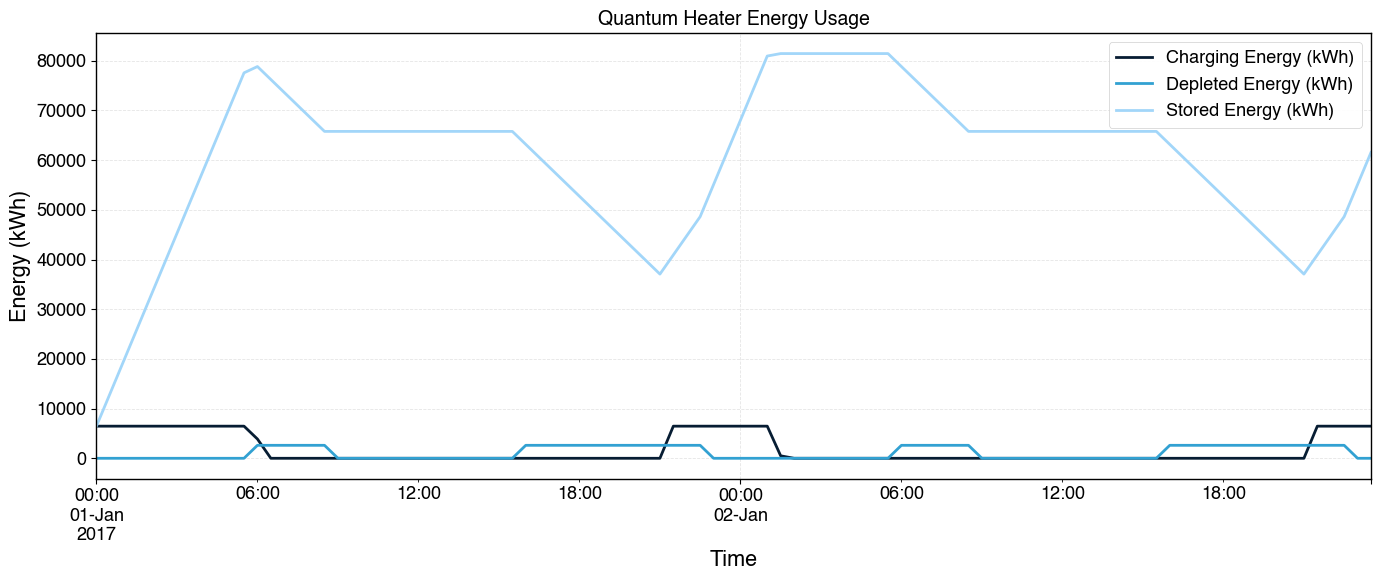

In [110]:
day_1 = ts_model[ts_model.seasons == 'Winter'].head(48*2)
fig, ax = plt.subplots(figsize=(14, 6))
day_1["qheater_charging_energy_kwh"].plot(ax=ax, label="Charging Energy (kWh)")
day_1["qheater_depleted_energy_kwh"].plot(ax=ax, label="Depleted Energy (kWh)")
day_1["qheater_storage_energy_kwh"].plot(ax=ax, label="Stored Energy (kWh)")
ax.set_title("Quantum Heater Energy Usage")
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel("Time")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
0.002268*(n_adopted_households)

9.3967776

Percentage of curtailed energy shifted with adoption rate (2%): 3.58%


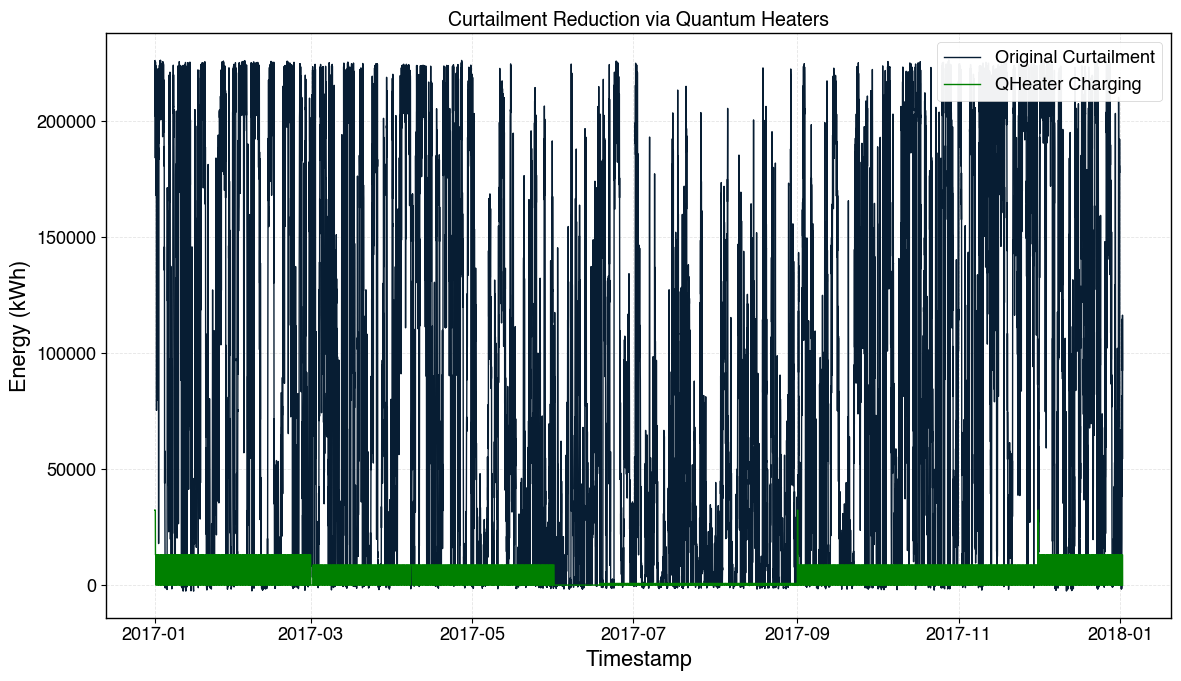

In [33]:
# check overall absoprption ratio')
total_shifted_kwh = ts_model['qheater_charging_energy_kwh'].sum()
total_curtailment_kwh = ts_curtailment['Curtailment_energy_kwh'].sum()

curtailment_shifted_percentage = (total_shifted_kwh / total_curtailment_kwh) * 100
print(f"Percentage of curtailed energy shifted with adoption rate ({qheater_adoption_rate}%): {curtailment_shifted_percentage:.2f}%")

# Plotting the results resampled into monthly intervals

plt.figure(figsize=(12, 7))
plt.plot(ts_model.index, ts_curtailment['Curtailment_energy_kwh'], label='Original Curtailment', linewidth=1)
# plt.plot(ts_model.index, ts_model['curtailment_unabsorbed_energy_kwh'], label='Curtailment Unabsorbed', color='orange', linewidth=1)
plt.plot(ts_model.index, ts_model['qheater_charging_energy_kwh'], label='QHeater Charging', color='green', linewidth=1)


plt.title('Curtailment Reduction via Quantum Heaters')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

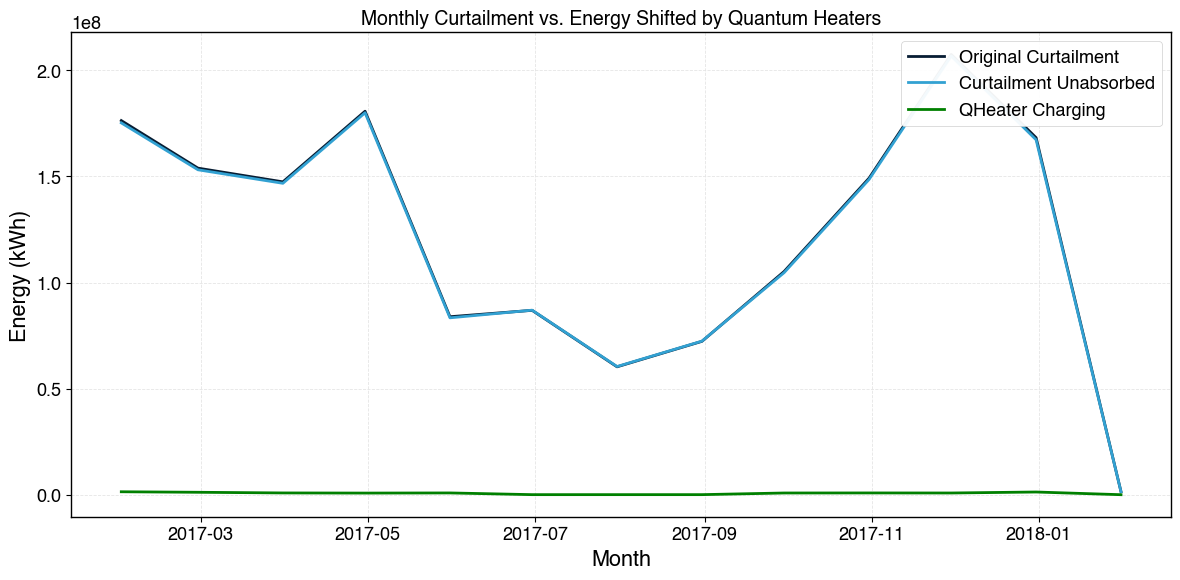

In [15]:
# Resample to monthly sums cause this is energy 
monthly = pd.DataFrame(index=ts_model.resample('ME').sum().index)
monthly['curtailment_energy_kwh'] = ts_curtailment['Curtailment_energy_kwh'].resample('ME').sum()
monthly['qheater_charging_energy_kwh'] = ts_model['qheater_charging_energy_kwh'].resample('ME').sum()
monthly['curtailment_unabsorbed_energy_kwh'] = ts_model['curtailment_unabsorbed_energy_kwh'].resample('ME').sum()


plt.figure(figsize=(12, 6))
plt.plot(monthly.index, monthly['curtailment_energy_kwh'], label='Original Curtailment', linewidth=2)
plt.plot(monthly.index, monthly['curtailment_unabsorbed_energy_kwh'], label='Curtailment Unabsorbed', linewidth=2)
plt.plot(monthly.index, monthly['qheater_charging_energy_kwh'], label='QHeater Charging',color = 'green', linewidth=2)

plt.title('Monthly Curtailment vs. Energy Shifted by Quantum Heaters')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [122]:
monthly

,curtailment_energy_kwh,qheater_charging_energy_kwh,curtailment_unabsorbed_energy_kwh
Timestamp,,,
2017-01-31,1.763058e+08,1428005.670,1.752132e+08
2017-02-28,1.539034e+08,1187648.280,1.531203e+08
2017-03-31,1.474407e+08,876597.540,1.467549e+08
2017-04-30,1.807163e+08,810145.791,1.799819e+08
2017-05-31,8.390122e+07,873769.806,8.338074e+07
2017-06-30,8.690671e+07,70693.350,8.698714e+07
2017-07-31,6.030179e+07,73049.795,6.043807e+07
2017-08-31,7.230728e+07,73049.795,7.240245e+07
2017-09-30,1.052229e+08,848320.200,1.046630e+08
